Setup imports

In [10]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    AddChanneld,
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    ScaleIntensityd,
    Spacingd,
    Invertd,
    RandRotate90d,
    RandRotated,
    RandGaussianNoised,
    RandAxisFlipd,
    RandAffined,
    NormalizeIntensityd,
    ToTensord
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss,DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

set portal vein dataset path

In [2]:
root_dir = ".\\3Dircadb1\\train"
train_images = sorted(glob.glob(os.path.join(root_dir, "Patient_" + "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, 'portalvein_' + "*.nii.gz")))

data_dicts = [{"image": images_name, "label": label_name} for images_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-2], data_dicts[-2:]  # 16 for train, 2 for validation
# set_determinism(seed = 0)  # set deterministic training for reproducibility

Setuup transforms for training and validation  

Here we use several transforms to augment the dataset:  

1. "LoadImaged" loads the CTA images and lables from NIFTI format files. 

2. "EnsureChannelFirstd" ensures the original data to construct "channel first" shape  

3. "Orientationd" unifies the data orientation based on the affine matrix  

4. "Spacingd" adjusts the spacing by "pixdim=(1.5, 1.5, 2.) based on the affine matrix  

5. "ScaleIntensityRanged" extracts intensity range [0, 500] and scales to [0, 1] 

6. "CropForegroundd" removes all zero borders to foucs on the valid body area of the images and labels  

7. "RandCropByPosNegLabeld" randomly crop path samples from big image based on pos/neg ratio 

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=500,
            b_min=0.0,
            b_max=1.0,
            clip=True,   # if clip = True, intensity < a_min and intensity > a_max will be zero
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),   # 裁剪得到图像中像素值大于0的区域，get only one
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(0.9, 0.9, 1.2), mode=("bilinear", "nearest")),  # resample image, pixedim is the target spacing
        RandCropByPosNegLabeld(
            keys=["image", "label"], 
            label_key="label",  # 用于查找前景和背景
            spatial_size=(96, 96, 96),   # ROI的大小
            pos=1,  # 与neg一起，计算选前景体素作为ROI中心的概率， pos / (pos + neg)
            neg=1,
            num_samples=8,  # 返回多少个子图
            image_key="image",   # 使用label==0 and image > image_threshold部分作为阴性样本
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(0.9, 0.9, 1.2), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


Check transforms in DataLoader

image shape: torch.Size([315, 257, 165]), label shape: torch.Size([315, 257, 165])


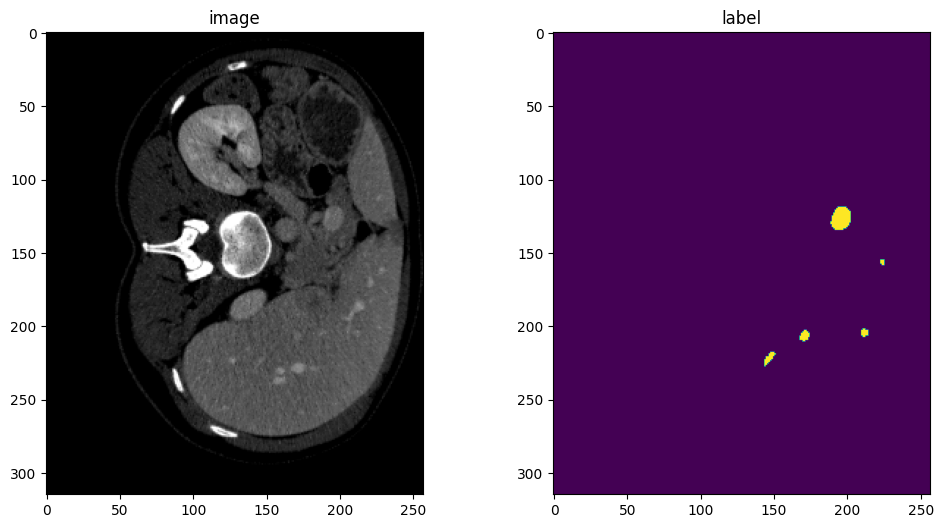

In [9]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)  
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


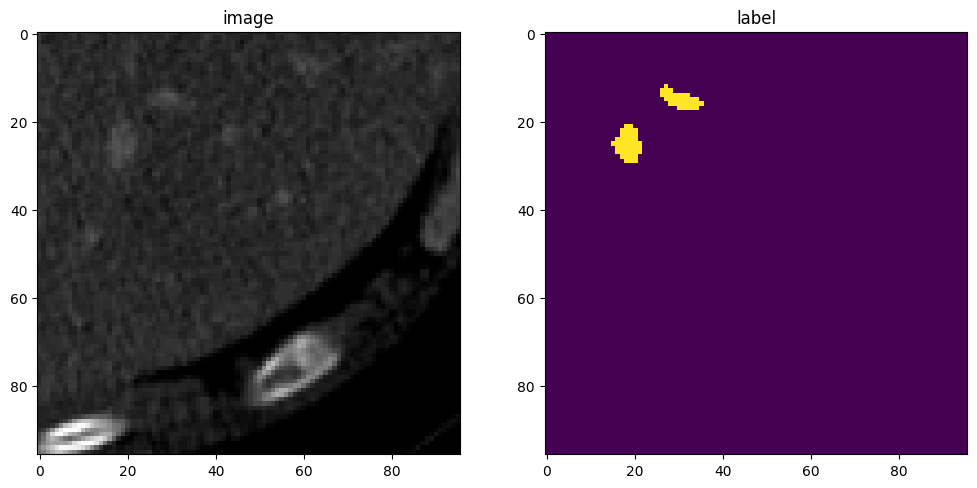

In [11]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
for i, check_data in enumerate(check_loader):
    if i ==10:
        image, label = (check_data["image"][0][0], check_data["label"][0][0])
        print(f"image shape: {image.shape}, label shape: {label.shape}")
        # plot the slice [:, :, 80]
        plt.figure("check", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title("image")
        plt.imshow(image[:, :, 80], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(label[:, :, 80])
        plt.show()

Define CacheDataset and DataLoader for training and validation  

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset. 
To achieve best performance, set "cache_rate=1.0" to cache all the data, if memory is not enough, set lower value. 
Users can also set "cache_num" instead of "cache_rate", will use the minimum value of the 2 settings. 
And set "num_workers" to enable multi-threads during caching. 
If want to try the regular Dataset, just change to use the commented code below.

In [4]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate batch_size x num_samples(in tranin_transforms) images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


In [14]:
step = 0
for batch_data in train_loader:
    step += 1
    inputs, labels = (
            batch_data['image'],
            batch_data['label']
        )
    labels[labels>0] = 1
    print(inputs.shape, inputs.min(), inputs.max())
    print(labels.shape, labels.min(), labels.max())
print(step)

torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
torch.Size([16, 1, 96, 96, 96]) metatensor(0.) metatensor(1.)
8


Create Model, Loss, Optimizer
According to the suggestion https://openaccess.thecvf.com/content_CVPRW_2020/papers/w57/Haft-Javaherian_A_Topological_Encoding_Convolutional_Neural_Network_for_Segmentation_of_3D_CVPRW_2020_paper.pdf , we used the normal cross-entropy loss
function for the initial optimization warm-up to decrease the required training time.


Unet args:
        spatial_dims: number of spatial dimensions.
        in_channels: number of input channels.
        out_channels: number of output channels.
        channels: sequence of channels. Top block first. The length of `channels` should be no less than 2.
        strides: sequence of convolution strides. The length of `stride` should equal to `len(channels) - 1`.
        kernel_size: convolution kernel size, the value(s) should be odd. If sequence,
            its length should equal to dimensions. Defaults to 3.
        up_kernel_size: upsampling convolution kernel size, the value(s) should be odd. If sequence,
            its length should equal to dimensions. Defaults to 3.
        num_res_units: number of residual units. Defaults to 0.
        act: activation type and arguments. Defaults to PReLU.
        norm: feature normalization type and arguments. Defaults to instance norm.
        dropout: dropout ratio. Defaults to no dropout.
        bias: whether to have a bias term in convolution blocks. Defaults to True.
            According to `Performance Tuning Guide <https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html>`_,
            if a conv layer is directly followed by a batch norm layer, bias should be False.
        adn_ordering: a string representing the ordering of activation (A), normalization (N), and dropout (D).
            Defaults to "NDA". See also: :py:class:`monai.networks.blocks.ADN`.

In [3]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,  # number of residual units. Defaults to 0.
    norm=Norm.BATCH,  # feature normalization type and arguments. Defaults to instance norm.
).to(device)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=1.0, lambda_ce=1.0)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")
print(device)

cuda:0


Execute a typical Pytorch training process

In [6]:
max_epochs = 600
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        labels[labels>0] = 1
        optimizer.zero_grad()  # 梯度归零
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()  # 梯度反向传播
        optimizer.step()  # update the parameters
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()  # 不启用Batch Normalization and Dropout
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_labels[val_labels>0] = 1
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                # torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600
1/8, train_loss: 1.7586
2/8, train_loss: 1.7377
3/8, train_loss: 1.7142
4/8, train_loss: 1.6950
5/8, train_loss: 1.6810
6/8, train_loss: 1.6884
7/8, train_loss: 1.6542
8/8, train_loss: 1.6406
epoch 1 average loss: 1.6962
----------
epoch 2/600
1/8, train_loss: 1.6334
2/8, train_loss: 1.6308
3/8, train_loss: 1.6143
4/8, train_loss: 1.5960
5/8, train_loss: 1.5967
6/8, train_loss: 1.5854
7/8, train_loss: 1.5805
8/8, train_loss: 1.5643
epoch 2 average loss: 1.6002
----------
epoch 3/600
1/8, train_loss: 1.5717
2/8, train_loss: 1.5608
3/8, train_loss: 1.5552
4/8, train_loss: 1.5364
5/8, train_loss: 1.5375
6/8, train_loss: 1.5304
7/8, train_loss: 1.5093
8/8, train_loss: 1.5210
epoch 3 average loss: 1.5403
----------
epoch 4/600
1/8, train_loss: 1.5028
2/8, train_loss: 1.5129
3/8, train_loss: 1.5049
4/8, train_loss: 1.4952
5/8, train_loss: 1.4920
6/8, train_loss: 1.4894
7/8, train_loss: 1.4872
8/8, train_loss: 1.4760
epoch 4 average loss: 1.4951
----------
epoch 5/600
1

Plot the loss and metric

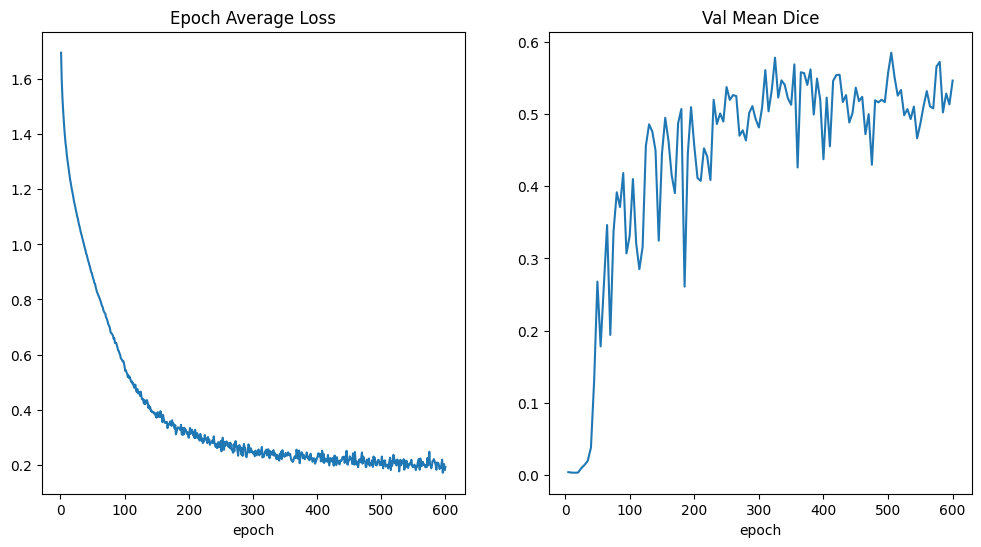

In [7]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

Check best model output with the input image and label 

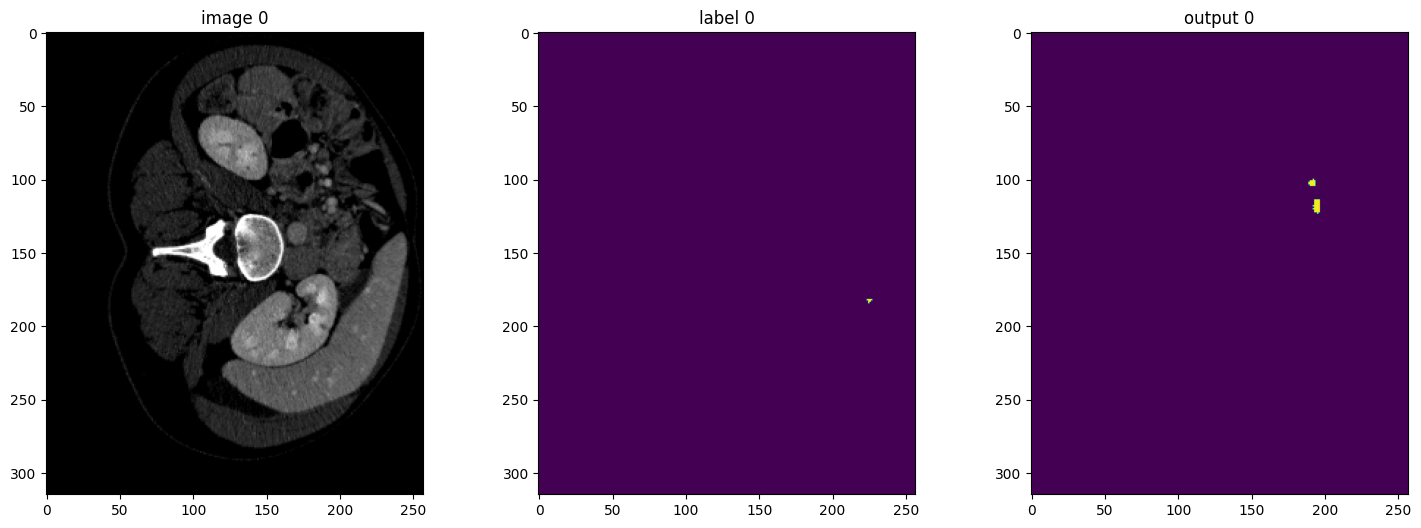

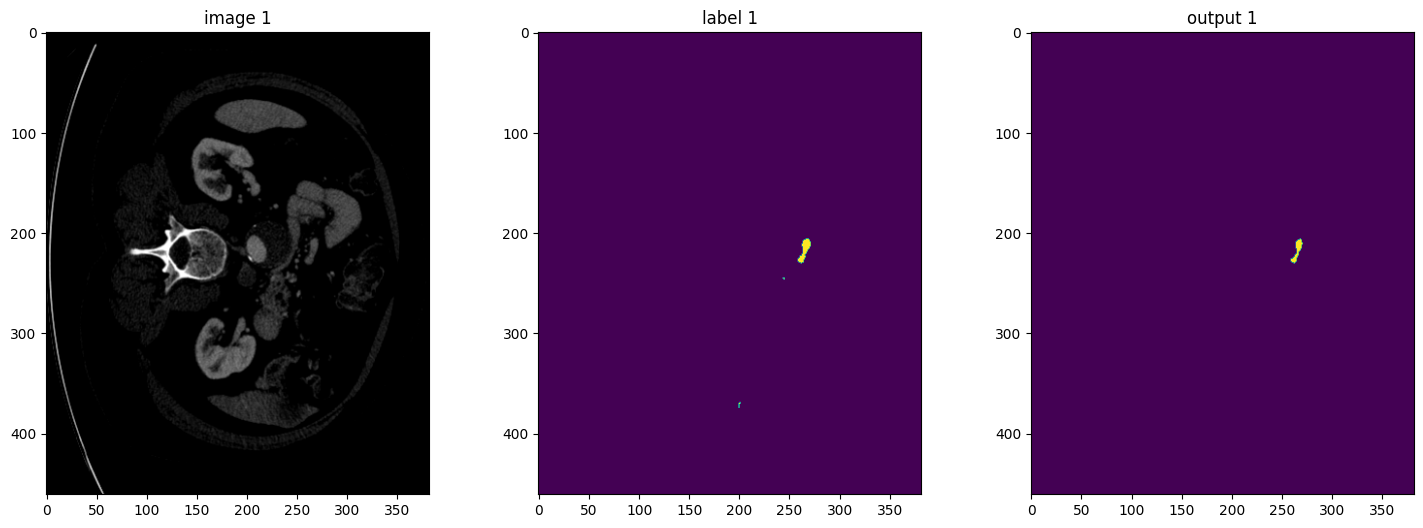

In [10]:
model.load_state_dict(torch.load("best_metric_model.pth"))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 40], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 40])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 40])
        plt.show()
        if i == 2:
            break

Evaluation on original image spacings  
首先在训练网络的spacing下预测输出，然后将输出重采样到原始图像

In [10]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(0.9, 0.9, 1.2), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        ScaleIntensityRanged(
            keys=["label"],
            a_min=0,
            a_max=255,
            b_min=0.0,
            b_max=1.0,
            clip=False,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [35]:
model.load_state_dict(torch.load("best_metric_model.pth"))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        # extract a list of `prections` and a list of `labels` with the `from_engine` utility
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)  
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.5883944034576416


Inference on Test Set

In [23]:
test_images = sorted(glob.glob(os.path.join(".\\3Dircadb1\\test", "Patient_" + "*.nii.gz")))

test_data = [{"image": image} for image in test_images]

test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(0.9, 0.9, 1.2), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",  # # invert the `pred` data field, also support multiple fields
            transform=test_org_transforms,
            orig_keys="image",   # get the previously applied pre_transforms information on the `img` data field
            meta_keys="pred_meta_dict",  # key field to save inverted meta data, every item maps to `keys`
            orig_meta_keys="image_meta_dict",  # use the meta data from `img_meta_dict` field when inverting
            meta_key_postfix="meta_dict",
            nearest_interp=False,  # don't change the interpolation mode of preprocessing when inverting
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),  # 保存结果为两个类，两个通道
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [22]:
model.load_state_dict(torch.load("best_metric_model.pth"))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model) # shape = (1, 2, 368, 352, 162)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        print(test_data[0]['pred'].shape)
        

torch.Size([2, 512, 512, 122])
torch.Size([2, 512, 512, 124])


加载模型继续训练

In [23]:
model.load_state_dict(torch.load("best_metric_model.pth"))

<All keys matched successfully>

In [28]:
max_epochs = 600
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        labels[labels>0] = 1
        optimizer.zero_grad()  # 梯度归零
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()  # 梯度反向传播
        optimizer.step()  # update the parameters
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()  # 不启用Batch Normalization and Dropout
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_labels[val_labels>0] = 1
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                # torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                torch.save(model.state_dict(), "best_metric_model_.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600
1/8, train_loss: 0.2372
2/8, train_loss: 0.1769
3/8, train_loss: 0.1799
4/8, train_loss: 0.1642
5/8, train_loss: 0.2191
6/8, train_loss: 0.2695
7/8, train_loss: 0.2124
8/8, train_loss: 0.2315
epoch 1 average loss: 0.2113
----------
epoch 2/600
1/8, train_loss: 0.1829
2/8, train_loss: 0.2042
3/8, train_loss: 0.2383
4/8, train_loss: 0.2837
5/8, train_loss: 0.1186
6/8, train_loss: 0.2138
7/8, train_loss: 0.1731
8/8, train_loss: 0.2133
epoch 2 average loss: 0.2035
----------
epoch 3/600
1/8, train_loss: 0.2305
2/8, train_loss: 0.1889
3/8, train_loss: 0.3115
4/8, train_loss: 0.2145
5/8, train_loss: 0.1943
6/8, train_loss: 0.2486
7/8, train_loss: 0.1874
8/8, train_loss: 0.2226
epoch 3 average loss: 0.2248
----------
epoch 4/600
1/8, train_loss: 0.2149
2/8, train_loss: 0.2799
3/8, train_loss: 0.1809
4/8, train_loss: 0.2443
5/8, train_loss: 0.2039
6/8, train_loss: 0.1404
7/8, train_loss: 0.2626
8/8, train_loss: 0.1713
epoch 4 average loss: 0.2123
----------
epoch 5/600
1

plot loss and metric values 

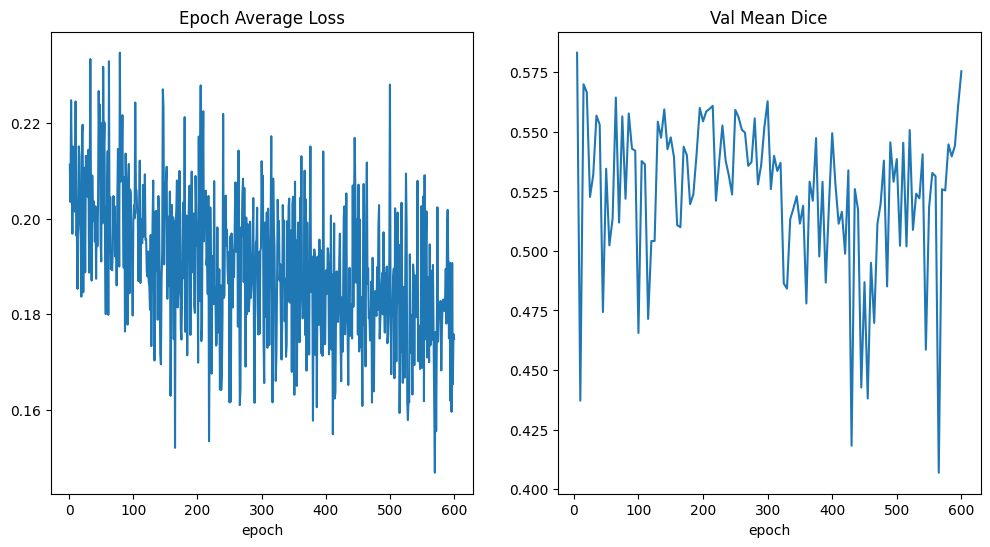

In [29]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

evalution in original image spacing

In [7]:
model.load_state_dict(torch.load("best_metric_model_.pth"))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        # extract a list of `prections` and a list of `labels` with the `from_engine` utility
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)  
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.5917623043060303


Change the loss function, from DiceCELoss to DiceLoss, load the trained model weight

In [4]:
def train(model, train_loader, train_ds, val_loader, loss_function, dice_metric, save_model_name, max_epochs = 600, val_interval = 5, best_metric = -1, best_metric_epoch = -1):
  

    global epoch_loss_values
    global metric_values
    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            labels[labels>0] = 1
            optimizer.zero_grad()  # 梯度归零
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()  # 梯度反向传播
            optimizer.step()  # update the parameters
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()  # 不启用Batch Normalization and Dropout
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    val_labels[val_labels>0] = 1
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    # torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                    torch.save(model.state_dict(), save_model_name)
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
    return epoch_loss_values, metric_values

In [19]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
model.load_state_dict(torch.load("best_metric_model_.pth"))

epoch_loss_values, metric_values = train(model, train_loader, train_ds, val_loader, loss_function, dice_metric, save_model_name='best_metric_model_dice.pth')

----------
epoch 1/600
1/8, train_loss: 0.2776
2/8, train_loss: 0.2347
3/8, train_loss: 0.1621
4/8, train_loss: 0.1588
5/8, train_loss: 0.2080
6/8, train_loss: 0.1732
7/8, train_loss: 0.1836
8/8, train_loss: 0.1994
epoch 1 average loss: 0.1997
----------
epoch 2/600
1/8, train_loss: 0.1800
2/8, train_loss: 0.1573
3/8, train_loss: 0.1873
4/8, train_loss: 0.1714
5/8, train_loss: 0.2211
6/8, train_loss: 0.2009
7/8, train_loss: 0.2519
8/8, train_loss: 0.2795
epoch 2 average loss: 0.2062
----------
epoch 3/600
1/8, train_loss: 0.2378
2/8, train_loss: 0.2718
3/8, train_loss: 0.2242
4/8, train_loss: 0.1677
5/8, train_loss: 0.2291
6/8, train_loss: 0.1896
7/8, train_loss: 0.2046
8/8, train_loss: 0.1791
epoch 3 average loss: 0.2130
----------
epoch 4/600
1/8, train_loss: 0.2669
2/8, train_loss: 0.2329
3/8, train_loss: 0.1249
4/8, train_loss: 0.1813
5/8, train_loss: 0.1623
6/8, train_loss: 0.2404
7/8, train_loss: 0.1327
8/8, train_loss: 0.1694
epoch 4 average loss: 0.1888
----------
epoch 5/600
1

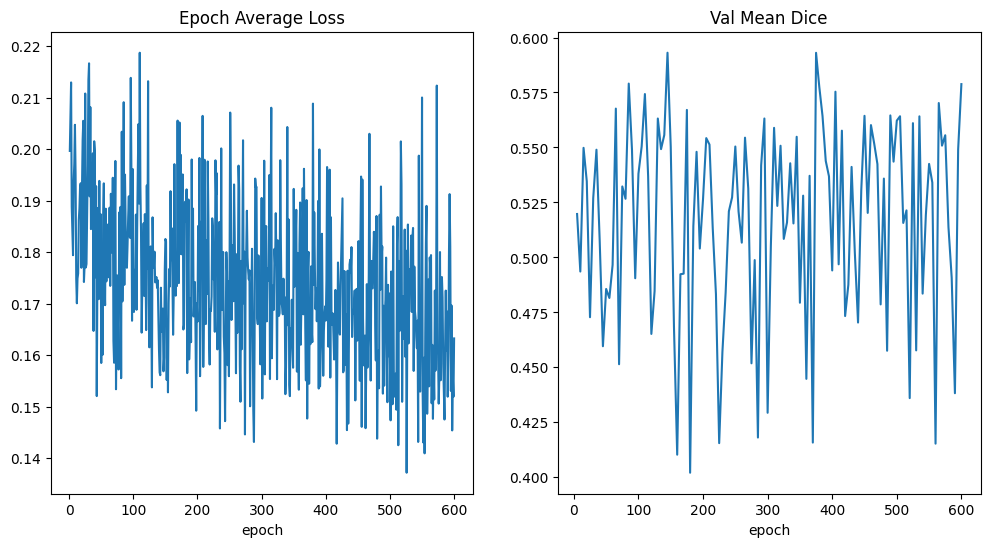

In [21]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
val_interval = 5
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [22]:
model.load_state_dict(torch.load("best_metric_model_dice.pth"))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        # extract a list of `prections` and a list of `labels` with the `from_engine` utility
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)  
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.5978331565856934


分析dice低的原因： 
1. 保存分割结果为nifity，可视化检查  

2. 计算sensitivity = (TP) / (TP + FN) and specificity = (TN) / (TN + FP), precision = (TP) / (TP + FP) 分析原因，可据此更改loss  

3. 进行数据增强，继续训练网络

In [24]:
model.load_state_dict(torch.load("best_metric_model_dice.pth"))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model) # shape = (1, 2, 368, 352, 162)
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

2023-10-08 09:46:20,976 INFO image_writer.py:197 - writing: out\Patient_10\Patient_10_seg.nii.gz
2023-10-08 09:46:26,342 INFO image_writer.py:197 - writing: out\Patient_19\Patient_19_seg.nii.gz


保存的分割结果是2个通道的，第1个通道是背景类，第2个通道是血管类，读取文件只保存第2个通道以对比分割结果  

可视化结果存在的问题： 
1. 分割结果断裂问题严重，topolopy loss, persistent homology（持续同调）针对是该问题  

2. 增加一些后处理删除非血管预测

In [4]:
import itk
from ImageProcess import array2itk
masks = itk.imread('.\\out\\Patient_10\\Patient_10_seg.nii.gz')
image = itk.imread('.\\3Dircadb1\\test\\Patient_10.nii.gz')
masksArray = itk.GetArrayFromImage(masks)
vascularMaskArray = masksArray[1, ...]
vascularMask = array2itk(vascularMaskArray, image)
itk.imwrite(vascularMask, '.\\out\\Patient_10\\Patient_10_seg.nii.gz')

masks = itk.imread('.\\out\\Patient_19\\Patient_19_seg.nii.gz')
image = itk.imread('.\\3Dircadb1\\test\\Patient_19.nii.gz')
masksArray = itk.GetArrayFromImage(masks)
vascularMaskArray = masksArray[1, ...]
vascularMask = array2itk(vascularMaskArray, image)
itk.imwrite(vascularMask, '.\\out\\Patient_19\\Patient_19_seg.nii.gz')

计算sensitivity = (TP) / (TP + FN) and specificity = (TN) / (TN + FP), precision = (TP) / (TP + FP) 分析原因，可据此更改loss

In [7]:
import numpy as np
def getConfusionMatrix(pred, gt):
    '''
    pred: 2d/3d array
    gt: 2d/3d array
    return: confusion = [[TP, FN], [FP, TN]]
    '''
    pred = (pred > 0).astype(np.int16)
    gt = (gt > 0).astype(np.int16)
    TP = np.count_nonzero(pred * gt)
    FP = np.count_nonzero(pred - (pred * gt)) 
    TN = len(np.where((pred + gt)==0)[0])
    FN = np.count_nonzero(gt - pred * gt)
    confusion = np.array([[TP, FN], [FP, TN]])
    return confusion

In [8]:
pred = itk.GetArrayFromImage(itk.imread('.\\out\\Patient_10\\Patient_10_seg.nii.gz'))
gt = itk.GetArrayFromImage(itk.imread('.\\3Dircadb1\\test\\portalvein_10.nii.gz'))
confusion = getConfusionMatrix(pred, gt)
TP, FN, FP, TN = confusion[0, 0], confusion[0, 1], confusion[1, 0], confusion[1, 1]
sensitivity = float(TP) / (TP + FN)
specificity = float(TN) / (TN + FP)
precision = float(TP) / (TP + FP)
print('sensitivity: ', sensitivity)
print('specificity: ', specificity)
print('precision: ', precision)

sensitivity:  0.7887013477767981
specificity:  0.9988242184335858
precision:  0.400019165655146


In [9]:
pred = itk.GetArrayFromImage(itk.imread('.\\out\\Patient_19\\Patient_19_seg.nii.gz'))
gt = itk.GetArrayFromImage(itk.imread('.\\3Dircadb1\\test\\portalvein_19.nii.gz'))
confusion = getConfusionMatrix(pred, gt)
TP, FN, FP, TN = confusion[0, 0], confusion[0, 1], confusion[1, 0], confusion[1, 1]
sensitivity = float(TP) / (TP + FN)
specificity = float(TN) / (TN + FP)
precision = float(TP) / (TP + FP)
print('sensitivity: ', sensitivity)
print('specificity: ', specificity)
print('precision: ', precision)

sensitivity:  0.3655834564254062
specificity:  0.9999000844340415
precision:  0.7620967741935484


In [11]:
print((0.7887013477767981 + 0.3655834564254062) / 2.)
print((0.400019165655146 + 0.7620967741935484) / 2.)

0.5771424021011021
0.5810579699243472


进行数据增强，训练网络   
在monai中进行数据增强有两种方法： 
1. 在训练时使用变换，即每个epoch应用的变换与之前的不同，数据量不会发生改变  

2. 训练前应用变换，增加数据量，在增加的数据量上训练模型，该方法需要写一个saveNifity的函数，将变换后的图像保存成nifity格式，参考https://blog.csdn.net/weixin_43229348/article/details/123047449 （存在问题，不要参考）,可以直接使用monai的SaveImaged，参考博客只能保存matrix，丢失dicom tag中的信息，

首先尝试在训练时使用变换的数据增强方案

In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=500,
            b_min=0.0,
            b_max=1.0,
            clip=True,   # if clip = True, intensity < a_min and intensity > a_max will be zero
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),   # 裁剪得到图像中像素值大于0的区域，get only one
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(0.9, 0.9, 1.2), mode=("bilinear", "nearest")),  # resample image, pixedim is the target spacing

        # data augmentation
        RandRotate90d(keys=['image', 'label'], prob = 0.2),  # 随机旋转图像，不影响数据量，但每个epoch的transforms不同
        RandAxisFlipd(keys=['image', 'label'], prob=0.2),  # 随机任意轴翻转
        RandGaussianNoised(keys=['image', 'label'], prob=0.2),  # 随机Gaussian噪声
        
        RandCropByPosNegLabeld(
            keys=["image", "label"], 
            label_key="label",  # 用于查找前景和背景
            spatial_size=(96, 96, 96),   # ROI的大小
            pos=1,  # 与neg一起，计算选前景体素作为ROI中心的概率， pos / (pos + neg)
            neg=1,
            num_samples=8,  # 返回多少个子图
            image_key="image",   # 使用label==0 and image > image_threshold部分作为阴性样本
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(0.9, 0.9, 1.2), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [5]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate batch_size x num_samples(in tranin_transforms) images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


In [12]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=1.0, lambda_ce=0.5)
model.load_state_dict(torch.load("best_metric_model_dice.pth"))

epoch_loss_values, metric_values = train(model, train_loader, train_ds, val_loader, loss_function, dice_metric, save_model_name='best_metric_model_dicece_aug.pth', max_epochs=400)

----------
epoch 1/400
1/8, train_loss: 0.3218
2/8, train_loss: 0.3284
3/8, train_loss: 2.1215
4/8, train_loss: 0.1714
5/8, train_loss: 0.2170
6/8, train_loss: 0.2287
7/8, train_loss: 0.1690
8/8, train_loss: 0.3376
epoch 1 average loss: 0.4869
----------
epoch 2/400
1/8, train_loss: 0.3181
2/8, train_loss: 0.4462
3/8, train_loss: 1.9195
4/8, train_loss: 0.2874
5/8, train_loss: 1.6880
6/8, train_loss: 0.3253
7/8, train_loss: 1.8251
8/8, train_loss: 1.6953
epoch 2 average loss: 1.0631
----------
epoch 3/400
1/8, train_loss: 0.3213
2/8, train_loss: 3.9113
3/8, train_loss: 0.4159
4/8, train_loss: 0.4705
5/8, train_loss: 0.4280
6/8, train_loss: 0.4235
7/8, train_loss: 3.7394
8/8, train_loss: 1.4359
epoch 3 average loss: 1.3932
----------
epoch 4/400
1/8, train_loss: 1.6763
2/8, train_loss: 0.3069
3/8, train_loss: 0.3959
4/8, train_loss: 0.3577
5/8, train_loss: 1.4558
6/8, train_loss: 0.3314
7/8, train_loss: 1.5850
8/8, train_loss: 0.2843
epoch 4 average loss: 0.7992
----------
epoch 5/400
1

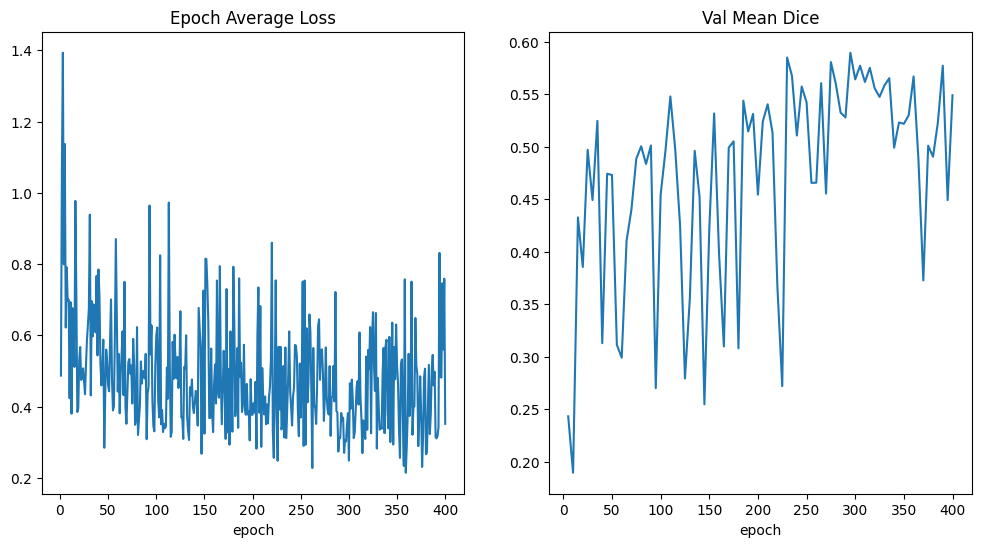

In [13]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
val_interval = 5
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [14]:
model.load_state_dict(torch.load("best_metric_model_dicece_aug.pth"))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        # extract a list of `prections` and a list of `labels` with the `from_engine` utility
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)  
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.6002688407897949


通过每个epoch的输入数据增强可以提升一点dice值，但提升效果非常小（0.59-->0.60），且由于每个epoch的数据存在差异，训练过程震荡明显

由于每个epoch的训练数据都有所不同，这种方法不方便控制收敛，因此尝试使用先生成增强数据再训练的方法
通过增加每张图像生成的子图数量（8-->64）增加训练数据量

In [20]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=500,
            b_min=0.0,
            b_max=1.0,
            clip=True,   # if clip = True, intensity < a_min and intensity > a_max will be zero
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),   # 裁剪得到图像中像素值大于0的区域，get only one
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(0.9, 0.9, 1.2), mode=("bilinear", "nearest")),  # resample image, pixedim is the target spacing
        RandCropByPosNegLabeld(
            keys=["image", "label"], 
            label_key="label",  # 用于查找前景和背景
            spatial_size=(96, 96, 96),   # ROI的大小
            pos=1,  # 与neg一起，计算选前景体素作为ROI中心的概率， pos / (pos + neg)
            neg=1,
            num_samples=64,  # 返回多少个子图
            image_key="image",   # 使用label==0 and image > image_threshold部分作为阴性样本
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(0.9, 0.9, 1.2), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [21]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate batch_size x num_samples(in tranin_transforms) images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 2/2 [00:07<00:00,  3.69s/it]


In [22]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=1.0, lambda_ce=1.0)
model.load_state_dict(torch.load("best_metric_model_dice.pth"))

epoch_loss_values, metric_values = train(model, train_loader, train_ds, val_loader, loss_function, dice_metric, save_model_name='best_metric_model_dicece.pth', max_epochs=600)

----------
epoch 1/600
1/16, train_loss: 0.1770
2/16, train_loss: 0.1686
3/16, train_loss: 0.2093
4/16, train_loss: 0.2188
5/16, train_loss: 0.2557
6/16, train_loss: 0.2321
7/16, train_loss: 0.2916
8/16, train_loss: 0.2102
9/16, train_loss: 0.1880
10/16, train_loss: 0.1860
11/16, train_loss: 0.1851
12/16, train_loss: 0.2055
13/16, train_loss: 0.1827
14/16, train_loss: 0.1984
15/16, train_loss: 0.1586
16/16, train_loss: 0.1757
epoch 1 average loss: 0.2027
----------
epoch 2/600
1/16, train_loss: 0.1506
2/16, train_loss: 0.2833
3/16, train_loss: 0.1479
4/16, train_loss: 0.3027
5/16, train_loss: 0.1864
6/16, train_loss: 0.1634
7/16, train_loss: 0.2374
8/16, train_loss: 0.1824
9/16, train_loss: 0.1966
10/16, train_loss: 0.1930
11/16, train_loss: 0.1934
12/16, train_loss: 0.1494
13/16, train_loss: 0.2280
14/16, train_loss: 0.1590
15/16, train_loss: 0.1982
16/16, train_loss: 0.2095
epoch 2 average loss: 0.1988
----------
epoch 3/600
1/16, train_loss: 0.1512
2/16, train_loss: 0.2709
3/16, tra

KeyboardInterrupt: 

In [23]:
model.load_state_dict(torch.load("best_metric_model_dicece.pth"))
model.eval()


with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        # extract a list of `prections` and a list of `labels` with the `from_engine` utility
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)  
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

Metric on original image spacing:  0.5441208481788635


通过增加每张图像的子图数量的方法并未改变原始数据集的形式，因此效果未有提升

保存增强后的数据，再使用Dataload加载训练， 由于存在随机性，需要对数据进行检查，删除重复数据

In [12]:
import math
generate_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], image_only=False),
        EnsureChannelFirstd(keys=["image", "label"]),  # ！！！！不然Spacingd时会忽略第1个通道，第1个通道的维度则不会发生变化
        # EnsureTyped(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(0.9, 0.9, 1.2), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes='RAS'),
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=500,b_min=0.0, b_max=1.0, clip=True,),
        
        # #=====data augmentation ======
        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10, rotate_range=0, shear_range=0), 
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=5./180*math.pi, range_y=5./180*math.pi, range_z=5./180*math.pi),  # radian
        RandGaussianNoised(keys='image', prob=0.5), 
        ])

        
from monai.transforms import SaveImage       

output_path = '.\\3Dircadb1\\aug'
number_runs = 8
check_ds = Dataset(data=data_dicts, transform=generate_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
for i in range(number_runs):
    name_folder = 'generated_data_' + str(i)
    # name_folder = 'original'
    if os.path.exists(os.path.join(output_path, name_folder)):
        shutil.rmtree(os.path.join(output_path, name_folder))
    os.mkdir(os.path.join(output_path, name_folder))
    output = os.path.join(output_path, name_folder)
    # print(output)
    for index, patient in enumerate(check_loader):
        # continue
        # print(patient['image'].max())
        SaveImage(squeeze_end_dims=True, output_dir=output, output_postfix="aug"+str(i), resample=False)(patient['image'][0])
        SaveImage(squeeze_end_dims=True, output_dir=output, output_postfix="aug"+str(i), resample=False)(patient['label'][0])
        # SaveImage(squeeze_end_dims=True, output_dir=output, output_postfix="", resample=False)(patient['image'][0])
        # SaveImage(squeeze_end_dims=True, output_dir=output, output_postfix="", resample=False)(patient['label'][0])
    

  

2023-10-12 14:18:07,754 INFO image_writer.py:197 - writing: 3Dircadb1\aug\generated_data_0\Patient_1\Patient_1_aug0.nii.gz
2023-10-12 14:18:08,971 INFO image_writer.py:197 - writing: 3Dircadb1\aug\generated_data_0\portalvein_1\portalvein_1_aug0.nii.gz
2023-10-12 14:18:26,889 INFO image_writer.py:197 - writing: 3Dircadb1\aug\generated_data_0\Patient_11\Patient_11_aug0.nii.gz
2023-10-12 14:18:31,668 INFO image_writer.py:197 - writing: 3Dircadb1\aug\generated_data_0\portalvein_11\portalvein_11_aug0.nii.gz
2023-10-12 14:18:42,191 INFO image_writer.py:197 - writing: 3Dircadb1\aug\generated_data_0\Patient_12\Patient_12_aug0.nii.gz
2023-10-12 14:18:43,919 INFO image_writer.py:197 - writing: 3Dircadb1\aug\generated_data_0\portalvein_12\portalvein_12_aug0.nii.gz
2023-10-12 14:18:53,558 INFO image_writer.py:197 - writing: 3Dircadb1\aug\generated_data_0\Patient_13\Patient_13_aug0.nii.gz
2023-10-12 14:18:55,316 INFO image_writer.py:197 - writing: 3Dircadb1\aug\generated_data_0\portalvein_13\portal

加载增强数据和原始数据进行训练

In [8]:
root_dir = ".\\3Dircadb1\\aug\\original"
train_images = sorted(glob.glob(os.path.join(root_dir, "Patient_*",  "Patient_" + "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, "portalvein_*", "portalvein_" + "*.nii.gz")))

data_dicts = [{"image": images_name, "label": label_name} for images_name, label_name in zip(train_images, train_labels)]

for i in range(8):
    aug_dir = os.path.join('.\\3Dircadb1\\aug', 'generated_data_' + str(i))
    aug_train_images = sorted(glob.glob(os.path.join(aug_dir, "Patient_*",  "Patient_" + "*.nii.gz")))
    aug_train_labels = sorted(glob.glob(os.path.join(aug_dir, "portalvein_*", "portalvein_" + "*.nii.gz")))
    for images_name, label_name in zip(aug_train_images, aug_train_labels):
        data_dicts.append({"image": images_name, "label": label_name})

print(len(data_dicts))
train_files, val_files = data_dicts[:-15], data_dicts[-15:]  # 124 for train, 15 for validation
set_determinism(seed = 0)  # set deterministic training for reproducibility

139


In [11]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        # ScaleIntensityRanged(
        #     keys=["image"],
        #     a_min=0,
        #     a_max=500,
        #     b_min=0.0,
        #     b_max=1.0,
        #     clip=True,   # if clip = True, intensity < a_min and intensity > a_max will be zero
        # ),
        ScaleIntensityd(keys=['image'], minv=0., maxv=1., channel_wise=True),
        # NormalizeIntensityd(keys=['image'], ), # 均值方差归一化
        CropForegroundd(keys=["image", "label"], source_key="image"),   # 裁剪得到图像中像素值大于0的区域，get only one
        # Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(keys=["image", "label"], pixdim=(0.9, 0.9, 1.2), mode=("bilinear", "nearest")),  # resample image, pixedim is the target spacing
        RandCropByPosNegLabeld(
            keys=["image", "label"], 
            label_key="label",  # 用于查找前景和背景
            spatial_size=(96, 96, 96),   # ROI的大小
            pos=1,  # 与neg一起，计算选前景体素作为ROI中心的概率， pos / (pos + neg)
            neg=1,
            num_samples=8,  # 返回多少个子图
            image_key="image",   # 使用label==0 and image > image_threshold部分作为阴性样本
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        # ScaleIntensityRanged(
        #     keys=["image"],
        #     a_min=0,
        #     a_max=500,
        #     b_min=0.0,
        #     b_max=1.0,
        #     clip=True,
        # ),
        ScaleIntensityd(keys=['image'], minv=0., maxv=1., channel_wise=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        # Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(keys=["image", "label"], pixdim=(0.9, 0.9, 1.2), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [12]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate batch_size x num_samples(in tranin_transforms) images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

tqdm is not installed, will not show the caching progress bar.


KeyboardInterrupt: 

In [ ]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)  
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)  
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [7]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=1.0, lambda_ce=1.0)
model.load_state_dict(torch.load("best_metric_model_dice.pth"))

global epoch_loss_values
global metric_values
epoch_loss_values = []
metric_values = []
train(model, train_loader, train_ds, val_loader, loss_function, dice_metric, save_model_name='best_metric_model_dicece_aug_1.pth', max_epochs=600)

----------
epoch 1/600
1/72, train_loss: 0.3276
2/72, train_loss: 0.3699
3/72, train_loss: 0.4043
4/72, train_loss: 0.5368
5/72, train_loss: 0.2743
6/72, train_loss: 0.2934
7/72, train_loss: 0.5004
8/72, train_loss: 0.3812
9/72, train_loss: 0.3696
10/72, train_loss: 0.3292
11/72, train_loss: 0.2551
12/72, train_loss: 0.5736
13/72, train_loss: 0.2789
14/72, train_loss: 0.3275
15/72, train_loss: 0.3111
16/72, train_loss: 0.3600
17/72, train_loss: 0.3010
18/72, train_loss: 0.4567
19/72, train_loss: 0.6100
20/72, train_loss: 0.2657
21/72, train_loss: 0.2820
22/72, train_loss: 0.3525
23/72, train_loss: 0.2014
24/72, train_loss: 0.2773
25/72, train_loss: 0.2409
26/72, train_loss: 0.1786
27/72, train_loss: 0.2077
28/72, train_loss: 0.3120
29/72, train_loss: 0.4385
30/72, train_loss: 0.3599
31/72, train_loss: 0.2709
32/72, train_loss: 0.2826
33/72, train_loss: 0.3989
34/72, train_loss: 0.5592
35/72, train_loss: 0.2376
36/72, train_loss: 0.2692
37/72, train_loss: 0.2781
38/72, train_loss: 0.555

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\transforms\transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\transforms\transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\transforms\croppad\dictionary.py", line 1002, in __call__
    self.randomize(d.get(self.label_key), fg_indices, bg_indices, d.get(self.image_key))
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\transforms\croppad\dictionary.py", line 984, in randomize
    self.cropper.randomize(label=label, fg_indices=fg_indices, bg_indices=bg_indices, image=image)
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\transforms\croppad\array.py", line 1154, in randomize
    fg_indices_, bg_indices_ = map_binary_to_indices(label, image, self.image_threshold)
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\transforms\utils.py", line 352, in map_binary_to_indices
    bg_indices = nonzero(img_flat & ~label_flat)
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\transforms\utils_pytorch_numpy_unification.py", line 186, in nonzero
    return torch.nonzero(x).flatten()
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\data\meta_tensor.py", line 276, in __torch_function__
    ret = super().__torch_function__(func, types, args, kwargs)
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\torch\_tensor.py", line 1295, in __torch_function__
    ret = func(*args, **kwargs)
RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 473378176 bytes.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\data\dataset.py", line 109, in __getitem__
    return self._transform(index)
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\data\dataset.py", line 926, in _transform
    data = self.transform(data, start=first_random)
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\transforms\compose.py", line 322, in __call__
    result = execute_compose(
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\transforms\compose.py", line 111, in execute_compose
    data = apply_transform(
  File "c:\ProgramData\anaconda3\envs\monai\lib\site-packages\monai\transforms\transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.croppad.dictionary.RandCropByPosNegLabeld object at 0x000001F39FAE74C0>
